In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data, SubsetWithAttributes
from utils import TRAINPATH, save_pickle, load_pickle, LANDMARK_DICT, DATAPATH, LANDMARKS_ANGLES_DICT, PICKLEDPATH, BODY_POSE_CONNECTIONS
from plot import *
from pose import poses_for_dataset
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]

mp_pose = mp.solutions.pose

In [3]:
shuffle = False

# Load the data
dataset, dataloader = load_data(path=TRAINPATH, batch_size=None, shuffle=shuffle, subset=False, classify=False)

In [73]:
df = load_pickle(PICKLEDPATH, "pose_landmark_all_df.pickle")
df_vis = load_pickle(PICKLEDPATH, "pose_landmark_vis_df.pickle")
numpy_data = load_pickle(PICKLEDPATH, "pose_landmark_numpy.pickle")
df_world = load_pickle(PICKLEDPATH, "pose_world_landmark_all_df.pickle")
df_vis_world = load_pickle(PICKLEDPATH, "pose_world_landmark_vis_df.pickle")
numpy_data_world = load_pickle(PICKLEDPATH, "pose_world_landmark_numpy.pickle")
labels_drop_na = load_pickle(PICKLEDPATH, "labels_drop_na.pickle")
annotated_images = load_pickle(PICKLEDPATH, "annotated_images.pickle")

In [119]:
indices = df_world.replace(to_replace='None', value=np.nan).dropna().index
dataset_no_null = SubsetWithAttributes(dataset, indices)

In [120]:
df_world = df_world.replace(to_replace='None', value=np.nan).dropna()

In [9]:
from data import create_angle_features

create_angle_features(df_world)

In [10]:
df_world.columns

Index(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
       'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
       'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX', 'label', 'quality',
       'LEFT_ELBOW_ANGLE', 'RIGHT_ELBOW_ANGLE', 'LEFT_ARMPIT_ANGLE',
       'RIGHT_ARMPIT_ANGLE', 'LEFT_CHEST_ANGLE', 'RIGHT_CHEST_ANGLE',
       'LEFT_WRIST_ANGLE', 'RIGHT_WRIST_ANGLE', 'LEFT_KNEE_ANGLE',
       'RIGHT_KNEE_ANGLE', 'LEFT_HIPFLEXOR_ANGLE', 'RIGHT_HIPFLEXOR_ANGLE',
       'LEFT_ADDUCTOR_ANGLE', 'RIGHT_ADDUCTOR_ANGLE', 'LEFT_ANKLE_ANGLE',
       'RIGHT_ANKLE_ANGLE'],
      dtype='object')

In [11]:
def calculate_length(v1, v2):
    return np.linalg.norm(v1-v2, ord=2)

In [12]:
calculate_length(np.array([.5,.5,.5]), np.array([.5,.5,0]))

0.5

In [13]:
numpy_data_world.shape

(627, 33, 3)

## Differences Good vs. Bad for Downward Dog?

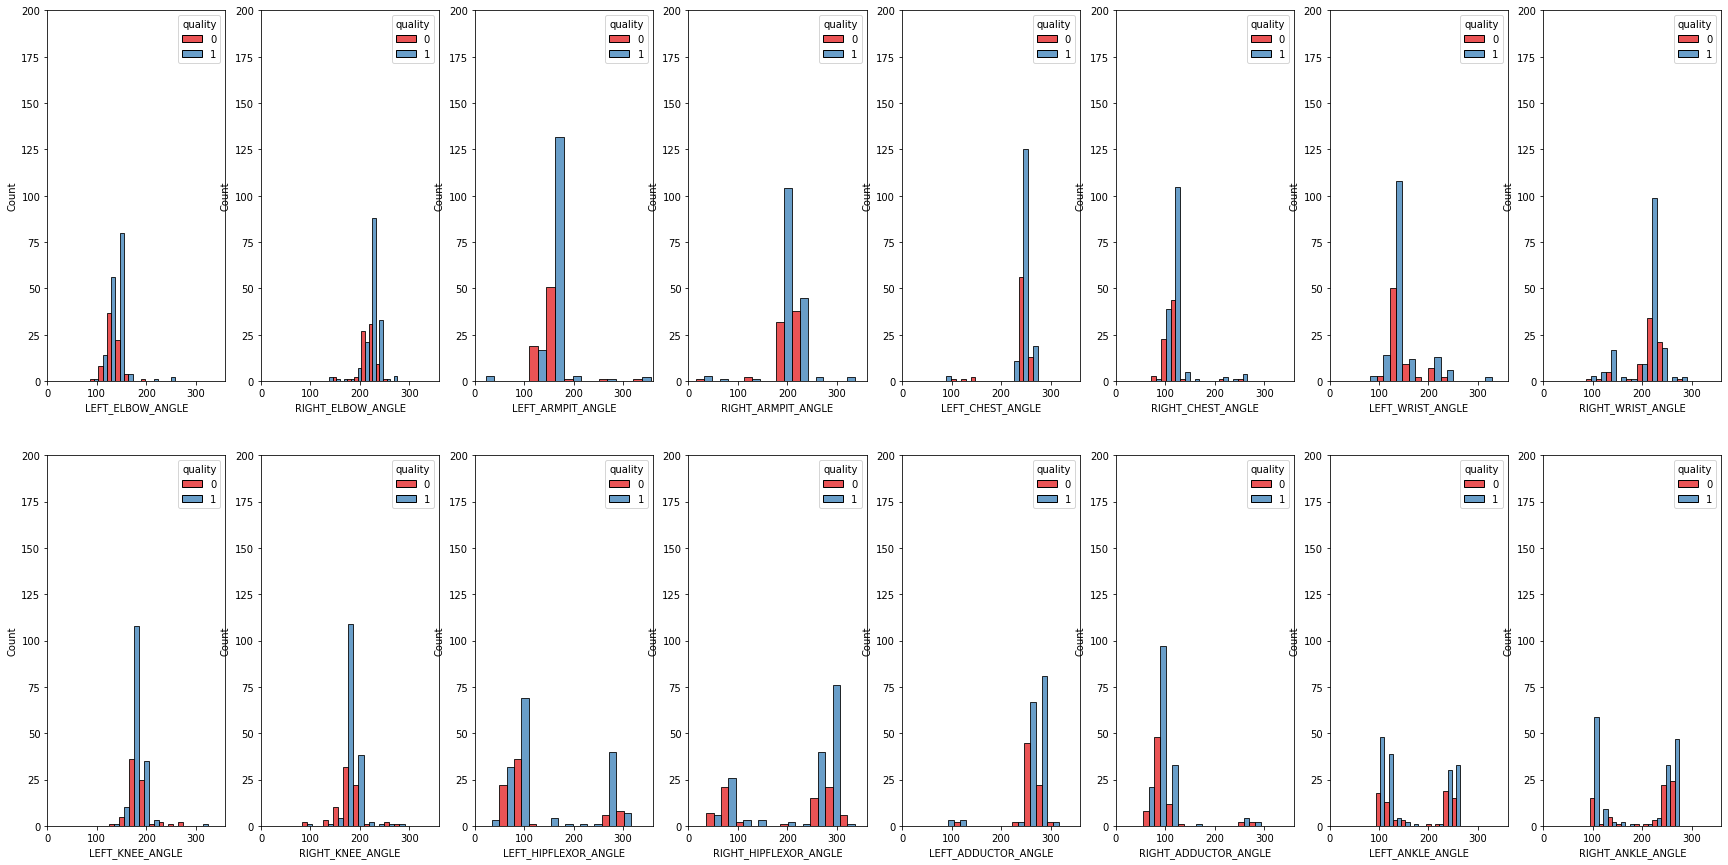

In [14]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==0], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

In [15]:
df_world[(df_world['RIGHT_HIPFLEXOR_ANGLE'] > 200) & (df_world['label']==1)]

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_WRIST_ANGLE,RIGHT_WRIST_ANGLE,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE,LEFT_HIPFLEXOR_ANGLE,RIGHT_HIPFLEXOR_ANGLE,LEFT_ADDUCTOR_ANGLE,RIGHT_ADDUCTOR_ANGLE,LEFT_ANKLE_ANGLE,RIGHT_ANKLE_ANGLE
78,"[0.12415708601474762, -0.6134564876556396, -0....","[0.09802109748125076, -0.6502240300178528, -0....","[0.09785489737987518, -0.6505221128463745, -0....","[0.09765223413705826, -0.650738000869751, -0.0...","[0.09192954748868942, -0.6449671387672424, -0....","[0.09249893575906754, -0.645858883857727, -0.0...","[0.09229876846075058, -0.6471447348594666, -0....","[0.005988951772451401, -0.6405362486839294, 0....","[-0.023412365466356277, -0.6164796948432922, -...","[0.0966932401061058, -0.5893012881278992, 0.00...",...,227.171332,127.364659,245.664570,165.171402,228.999447,212.625211,115.808061,111.933226,130.519139,243.823639
79,"[0.2322123646736145, -0.6170550584793091, -0.0...","[0.2132633477449417, -0.6599872708320618, -0.0...","[0.21321362257003784, -0.6604640483856201, -0....","[0.2131035029888153, -0.6607555150985718, -0.0...","[0.20351703464984894, -0.6545231342315674, -0....","[0.20422883331775665, -0.6554627418518066, -0....","[0.204323410987854, -0.6565916538238525, -0.08...","[0.12551063299179077, -0.6672677397727966, 0.0...","[0.08620074391365051, -0.6425731182098389, -0....","[0.20322942733764648, -0.5969173312187195, -0....",...,216.280496,214.311579,243.689432,166.489193,228.259662,203.807459,113.848919,106.362367,118.861264,250.273303
81,"[0.11555536091327667, -0.672224223613739, -0.1...","[0.09796521067619324, -0.7113235592842102, -0....","[0.09788462519645691, -0.7116801142692566, -0....","[0.09782372415065765, -0.7122775912284851, -0....","[0.08054763078689575, -0.7052298188209534, -0....","[0.08110866695642471, -0.7063869833946228, -0....","[0.08112461864948273, -0.7074186205863953, -0....","[0.04409465566277504, -0.6939890384674072, -0....","[-0.030777085572481155, -0.6690359115600586, -...","[0.10120207816362381, -0.6434201598167419, -0....",...,217.226157,213.379476,203.375345,158.134633,143.959341,205.278501,121.455454,108.320505,119.089504,254.837196
82,"[0.1057049036026001, -0.6223097443580627, -0.0...","[0.0785648450255394, -0.6587504744529724, -0.0...","[0.07839888334274292, -0.65907222032547, -0.01...","[0.07830672711133957, -0.6593927145004272, -0....","[0.07034029811620712, -0.6535415053367615, -0....","[0.07100078463554382, -0.6545203328132629, -0....","[0.07050703465938568, -0.655782163143158, -0.0...","[-0.010286476463079453, -0.6458963751792908, 0...","[-0.04479348286986351, -0.6229032278060913, -0...","[0.08082674443721771, -0.5961799621582031, 0.0...",...,114.250001,136.584109,241.566386,162.602962,227.928316,210.876318,110.418392,111.347641,127.122905,239.818265
83,"[0.04334200173616409, -0.6546162962913513, -0....","[0.011169768869876862, -0.6823368668556213, -0...","[0.010891102254390717, -0.682590901851654, 0.0...","[0.010595232248306274, -0.6828777194023132, 0....","[0.012740001082420349, -0.679013192653656, -0....","[0.013090148568153381, -0.6801578402519226, -0...","[0.012612231075763702, -0.6812337040901184, -0...","[-0.08080927282571793, -0.641900897026062, 0.0...","[-0.07443814724683762, -0.6297925710678101, -0...","[0.01841381937265396, -0.6201812028884888, 0.0...",...,146.841274,114.154606,213.876970,164.167775,213.480782,210.242740,126.812242,102.176805,119.244183,251.781185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,"[-0.12506455183029175, -0.6144317388534546, -0...","[-0.10845209658145905, -0.6500367522239685, -0...","[-0.10828446596860886, -0.6506344079971313, -0...","[-0.10825798660516739, -0.6506553888320923, -0...","[-0.1124550923705101, -0.6540589928627014, -0....","[-0.11228956282138824, -0.6548264026641846, -0...","[-0.112459197640419, -0.6562641859054565, -0.0...","[0.00042016245424747467, -0.6282052397727966, ..."

## Differences Good vs. Bad for Warrior I?

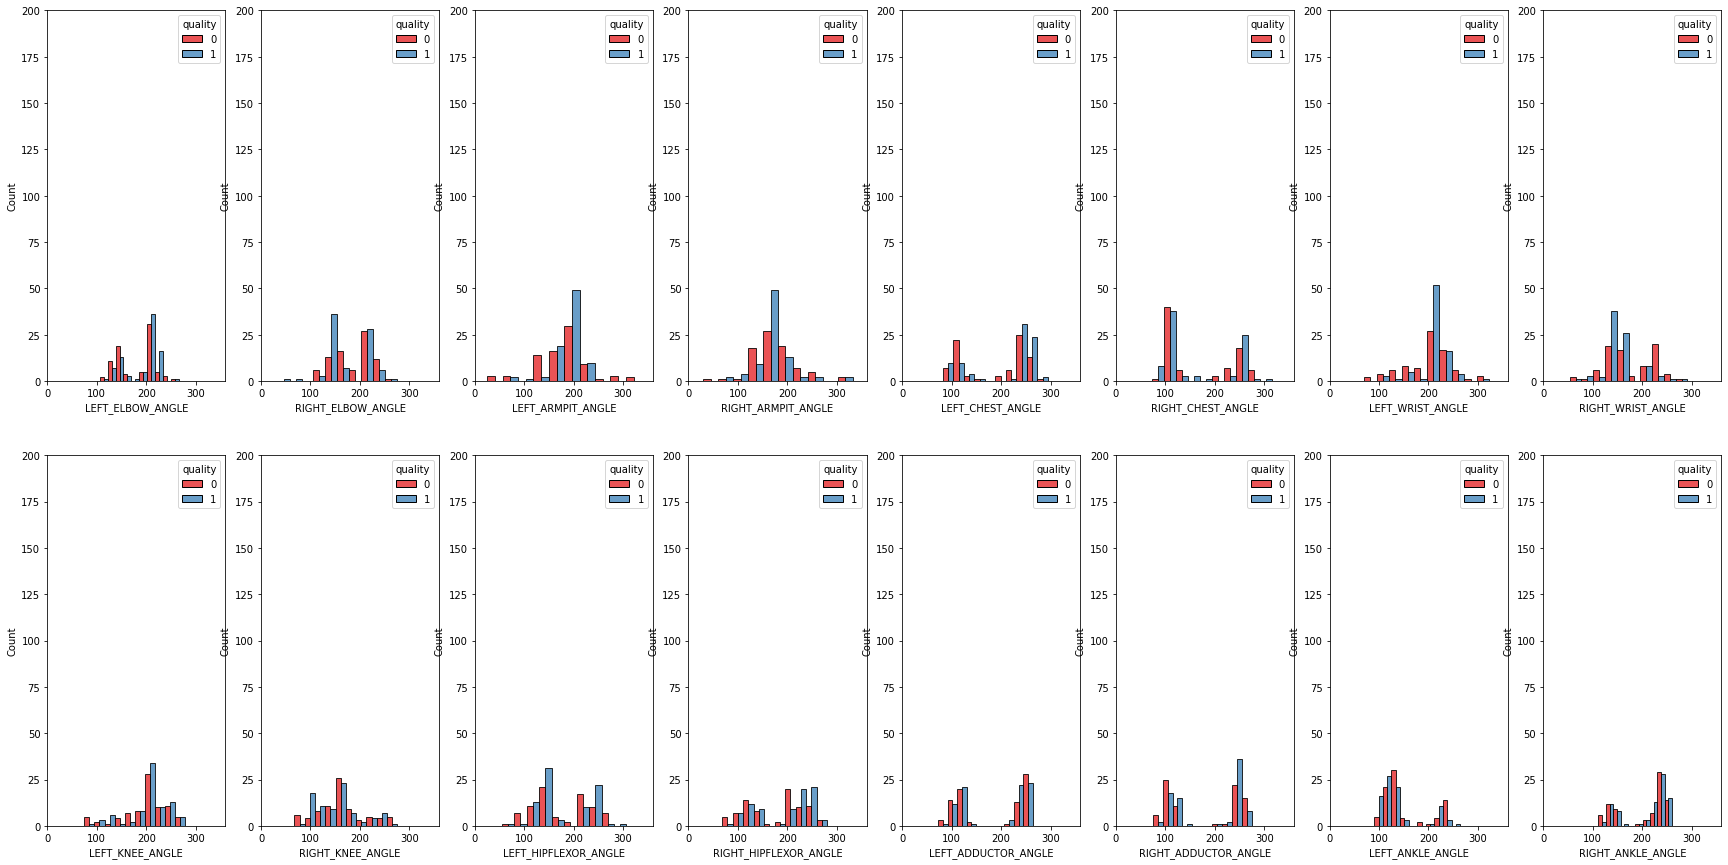

In [17]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==1], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

## Differences Good vs. Bad for Warrioir II?

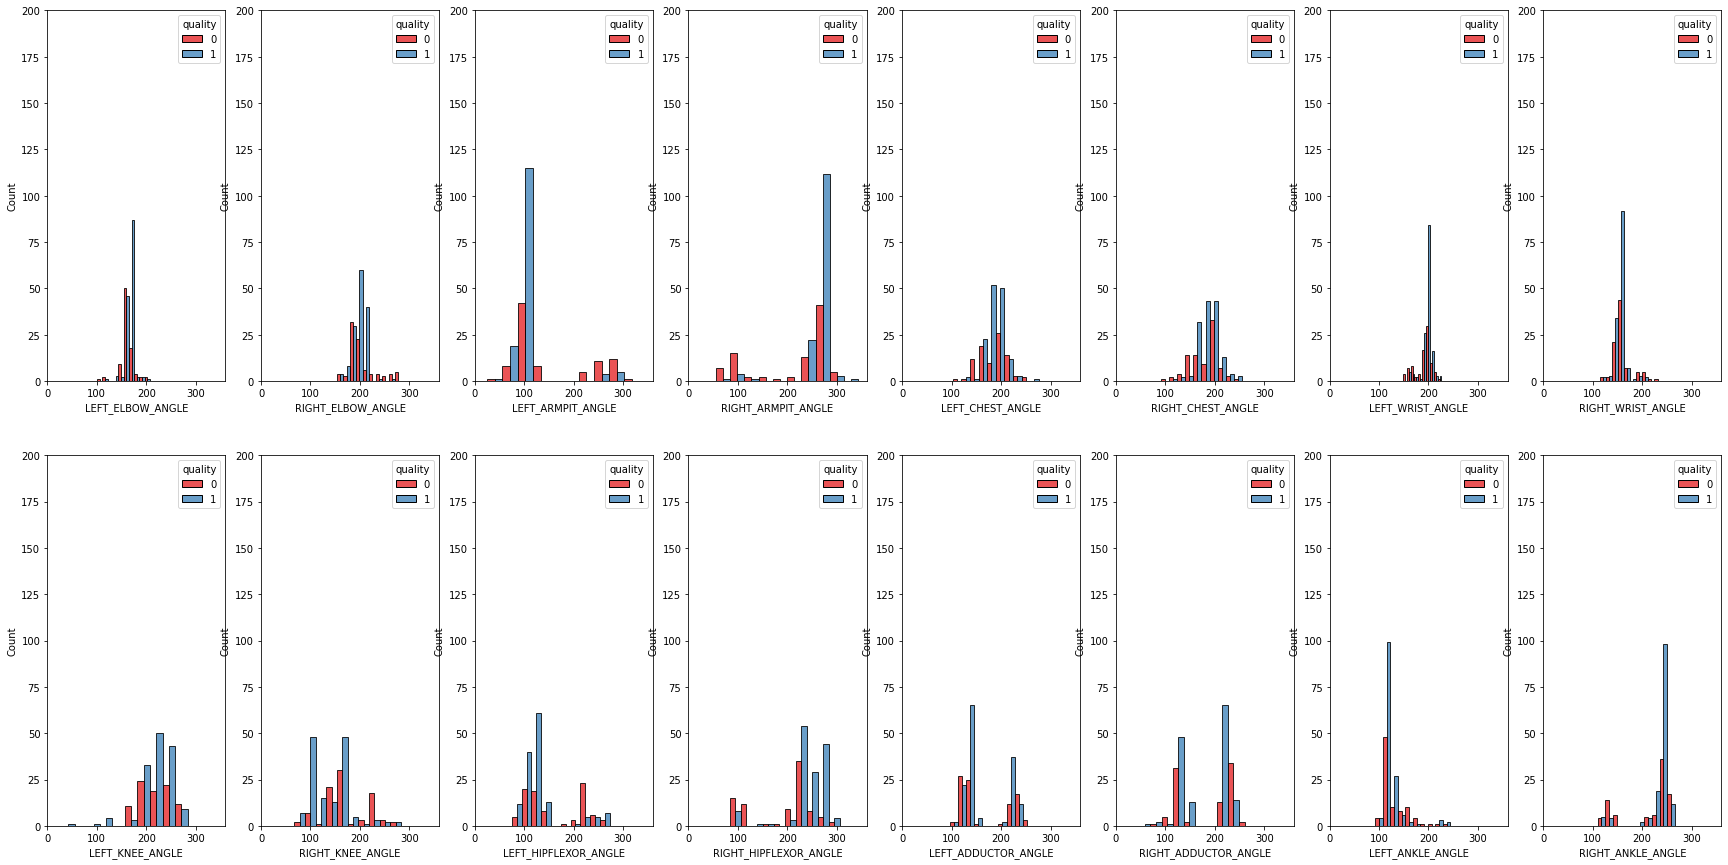

In [18]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==2], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

In [19]:
points = np.array([[0, 0, 1],[1, 0, -1],[0, 0, 1]])

In [20]:
modified = points - np.tile(points[:,1],(3,1)).T

In [21]:
modified

array([[ 0,  0,  1],
       [ 1,  0, -1],
       [ 0,  0,  1]])

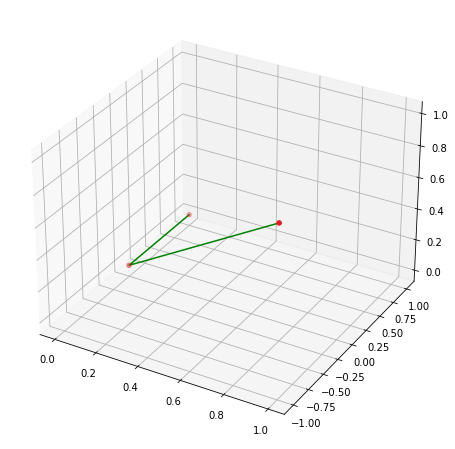

In [22]:
from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt


px = points[0]
py = points[1]
pz = points[2]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(px, py, pz)
ax.plot(points[0],points[1],points[2],color = 'g')
plt.show()

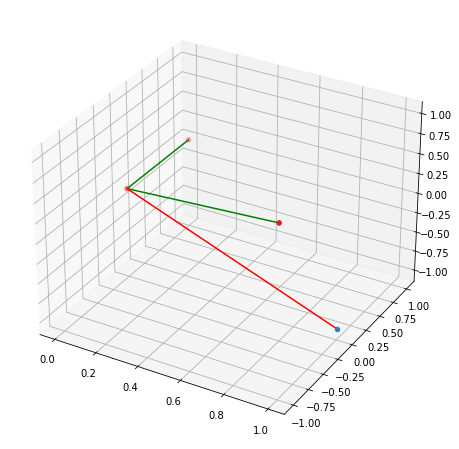

In [41]:
px = modified[0]
py = modified[1]
pz = modified[2]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(px, py, pz)
ax.scatter3D(cross[0], cross[1], cross[2])
ax.plot3D(modified[0],modified[1],modified[2],color = 'g')
ax.plot3D(np.array([modified[0][1],cross[0]]), np.array([modified[1][1],cross[1]]), np.array([modified[2][1],cross[2]]), color='r')
plt.show()

In [24]:
ref = np.array([1,0,0])
cross = np.cross(modified[:,0], modified[:,2])
sign = np.sign(np.dot(cross, ref))
if sign == 0:
    raise ValueError('Reference Vector, v1 and v2 are in the same plane!')
c = sign * np.linalg.norm(cross)
angle = np.degrees(np.arctan2(c, np.dot(modified[:,0], modified[:,2])))
corrected_angle = (angle + 360) % 360

In [43]:
np.linalg.norm(cross)

1.4142135623730951

In [42]:
c

1.4142135623730951

In [26]:
np.dot(modified[:,0], modified[:,2])

-1

In [27]:
corrected_angle

125.26438968275465

In [28]:
angle

125.26438968275465

In [163]:
x1 = .5
y1 = .5

In [63]:
x2 = 5*np.cos(np.radians(53.13))
y2 = 5*np.sin(np.radians(53.13))

In [64]:
x2

3.0000071456633126

In [65]:
y2

3.9999946407425426

In [68]:
lm_1 = np.array([1,1,1])
lm_2 = np.array([1,2,2])
lm_3 = np.array([2,1,0])

In [ ]:
lm_2_lm_1_vector = lm_1 - lm_2
lm_2_lm_3_vector = lm_3 - lm_2
# calc angle using https://ch.mathworks.com/matlabcentral/answers/501449-angle-betwen-two-3d-vectors-in-the-range-0-360-degree
cross = np.cross(lm_2_lm_3_vector, lm_2_lm_1_vector)
sign = np.sign(np.dot(cross, ref))
if sign == 0:
    raise ValueError('Reference Vector, v1 and v2 are in the same plane!')
c = sign * np.linalg.norm(cross)
angle = np.degrees(np.arctan2(c, np.dot(lm_2_lm_3_vector, lm_2_lm_1_vector)))
# get angle between 0 - 360
corrected_angle = (angle + 360) % 360

In [213]:
3*np.cos(np.radians(30))

2.598076211353316

In [214]:
3*np.sin(np.radians(30))

1.4999999999999998

In [217]:
4*np.cos(np.radians(-60))

2.0000000000000004

In [218]:
4*np.sin(np.radians(-60))

-3.4641016151377544

In [220]:
base_coordinate = np.array([[0],[0],[0]])
length1 = 3
length2 = 4
angle_between = 90

In [222]:
stick_man = np.array([[0,0,1,-1,1,-1],[0,1,2,2,-1,-1]])

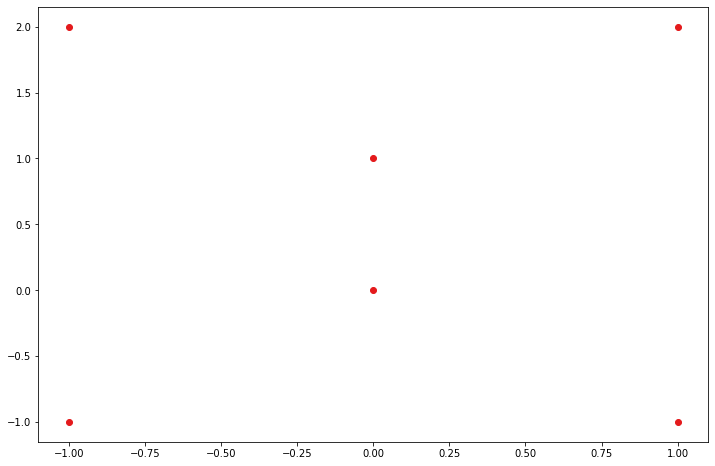

In [225]:
plt.scatter(stick_man[0], stick_man[1])

In [236]:
angle = np.degrees(np.arctan2(stick_man[1],stick_man[0]))

In [237]:
dist = np.linalg.norm(stick_man,axis=0)

In [257]:
dist = np.array([0,2,4,6,2,2])

In [258]:
x = dist * np.cos(np.radians(angle))
y = dist * np.sin(np.radians(angle))

In [259]:
x

array([ 0.00000000e+00,  1.22464680e-16,  1.78885438e+00, -2.68328157e+00,
        1.41421356e+00, -1.41421356e+00])

In [260]:
y

array([ 0.        ,  2.        ,  3.57770876,  5.36656315, -1.41421356,
       -1.41421356])

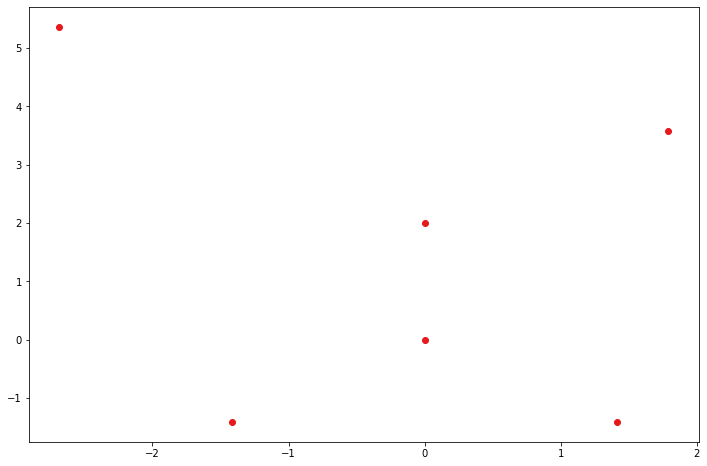

In [261]:
plt.scatter(x,y)

In [6]:
points = np.array([[0, 1],[0, 2],[0, 3]])

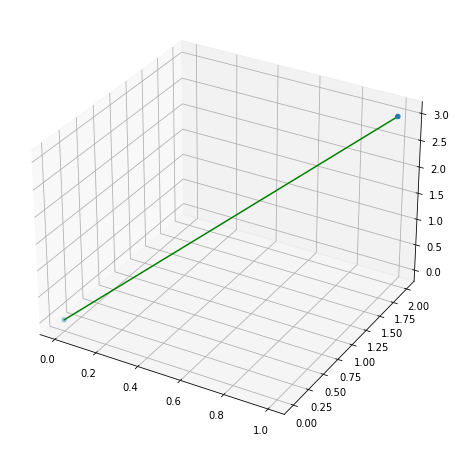

In [7]:
px = points[0]
py = points[1]
pz = points[2]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(px, py, pz)
ax.plot(points[0],points[1],points[2],color = 'g')
plt.show()

In [8]:
points[:,1]

array([1, 2, 3])

In [9]:
points[0:2, 1]

array([1, 2])

In [10]:
# xy axis
xy_points = points[0:2, 1]

In [11]:
#yz axis
yz_points = points[1:3, 1]

In [12]:
yz_points

array([2, 3])

In [13]:
xy_angle = np.degrees(np.arctan2(xy_points[1], xy_points[0]))

In [14]:
yz_angle = np.degrees(np.arctan2(yz_points[1], yz_points[0]))

In [15]:
xy_dist = np.linalg.norm(xy_points)

In [16]:
yz_dist = np.linalg.norm(yz_points)

In [17]:
xy_x = xy_dist * np.cos(np.radians(xy_angle))
xy_y = xy_dist * np.sin(np.radians(xy_angle))

In [18]:
yz_y = yz_dist * np.cos(np.radians(yz_angle))
yz_z = yz_dist * np.sin(np.radians(yz_angle))

In [19]:
xy_x

1.0000000000000002

In [20]:
xy_y

2.0

In [21]:
yz_y

2.0

In [22]:
yz_z

2.9999999999999996

In [99]:
annotated_images = [img for img in annotated_images if img is not None]

In [202]:
# assuming already normalized

def calc_2d_angles(vec_2d):
    return np.degrees(np.arctan2(vec_2d[1], vec_2d[0]))

def calc_xyz_angles(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_angle = calc_2d_angles(xy_points)
    yz_angle = calc_2d_angles(yz_points)
    
    return xy_angle, yz_angle

def calc_xyz_dist(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_dist = np.linalg.norm(xy_points, axis=0)
    yz_dist = np.linalg.norm(yz_points, axis=0)
    
    return xy_dist, yz_dist

def calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist):
    x, y1 = calc_2d_points(xy_angle, xy_dist)
    y2, z = calc_2d_points(yz_angle, yz_dist)
    
    return x, y1, z
    
def calc_2d_points(angle, dist):
    a = dist * np.cos(np.radians(angle))
    b = dist * np.sin(np.radians(angle))
    return a, b

In [249]:
RIGHT_HIP = 24
norm_185 = numpy_data_world[185] - np.tile(numpy_data_world[185][RIGHT_HIP], (numpy_data_world[185].shape[0],1))

In [250]:
norm_185

array([[ 0.11718091, -0.63729621, -0.30691667],
       [ 0.12700355, -0.67228289, -0.28610711],
       [ 0.12706373, -0.67269452, -0.28502508],
       [ 0.12723871, -0.67290844, -0.28500043],
       [ 0.09389358, -0.67041577, -0.28754388],
       [ 0.09407808, -0.67139871, -0.28817817],
       [ 0.09390414, -0.67245211, -0.28768416],
       [ 0.17414583, -0.64095826, -0.17207732],
       [ 0.02489277, -0.64220263, -0.18792905],
       [ 0.13790767, -0.60485794, -0.26906543],
       [ 0.09346281, -0.60258903, -0.27172871],
       [ 0.27448774, -0.48148738, -0.09373657],
       [-0.05838021, -0.4715357 , -0.13242664],
       [ 0.48157512, -0.48622249, -0.17033946],
       [-0.2907835 , -0.42220099, -0.12508672],
       [ 0.59683981, -0.46267123, -0.32956081],
       [-0.50504566, -0.38852896, -0.18480814],
       [ 0.62367814, -0.44637693, -0.34757053],
       [-0.55240984, -0.38226105, -0.1919046 ],
       [ 0.61769264, -0.46305276, -0.3776228 ],
       [-0.57274658, -0.40356006, -0.226

In [251]:
xy_angle, yz_angle = calc_xyz_angles(norm_185.T)

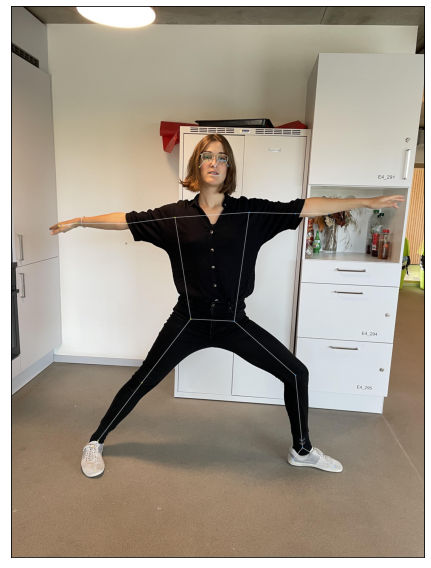

In [253]:
plot_image(annotated_images[185])

In [254]:
norm_164 = numpy_data_world[164] - np.tile(numpy_data_world[164][RIGHT_HIP], (numpy_data_world[164].shape[0],1))

In [255]:
xy_dist, yz_dist = calc_xyz_dist(norm_164.T)

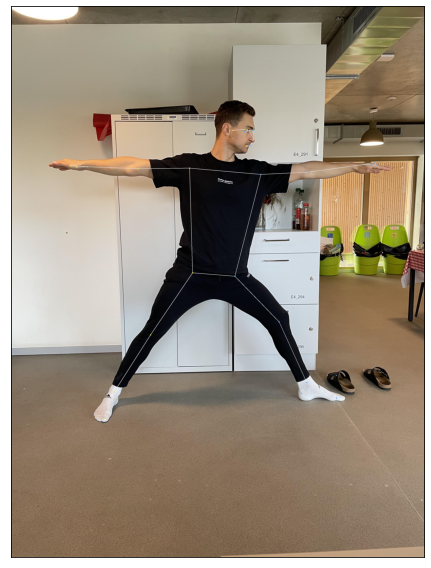

In [256]:
plot_image(annotated_images[164])

In [257]:
numpy_data_world[164].T

array([[ 0.19350737,  0.18790787,  0.18806113,  0.18805856,  0.16878858,
         0.16923308,  0.16918254,  0.14521414,  0.05992569,  0.17813984,
         0.15253523,  0.23273923, -0.11276584,  0.5053997 , -0.37305406,
         0.71466756, -0.58886057,  0.76869285, -0.63957858,  0.77477419,
        -0.64731067,  0.7259317 , -0.60162908,  0.11380257, -0.11437884,
         0.33583039, -0.27510923,  0.46847266, -0.46400931,  0.49005938,
        -0.48351902,  0.58079171, -0.53546071],
       [-0.62088507, -0.66012818, -0.6606285 , -0.66081905, -0.65803206,
        -0.65912783, -0.660294  , -0.64758146, -0.64647216, -0.59496695,
        -0.59299278, -0.48022559, -0.50868714, -0.50422996, -0.50796878,
        -0.48786283, -0.46572605, -0.47915041, -0.45826662, -0.50217283,
        -0.47245789, -0.4912616 , -0.46400204,  0.00323966, -0.0032068 ,
         0.2817198 ,  0.31566918,  0.57846546,  0.59186888,  0.62006938,
         0.63248217,  0.65620524,  0.69642466],
       [-0.26152617, -0.2431

In [258]:
bx, by, bz = numpy_data_world[164].T[0], numpy_data_world[164].T[1], numpy_data_world[164].T[2]

In [259]:
px, py, pz = calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist)

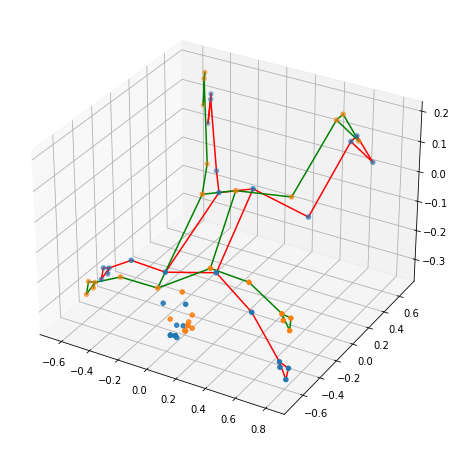

In [260]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(px, py, pz)
ax.scatter3D(bx, by, bz)
#ax.plot(points[0],points[1],points[2],color = 'g')
for i,j in BODY_POSE_CONNECTIONS:
    ax.plot([px[i],px[j]], [py[i],py[j]], [pz[i],pz[j]], color='r')
for i,j in BODY_POSE_CONNECTIONS:
    ax.plot([bx[i],bx[j]], [by[i],by[j]], [bz[i],bz[j]], color='g')
plt.show()